In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from matplotlib.pyplot import MultipleLocator
from sklearn.feature_selection import RFE, RFECV,VarianceThreshold, SelectKBest, r_regression, SelectFromModel
from sklearn.preprocessing import StandardScaler,MinMaxScaler,Normalizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix
from scipy.stats import pearsonr

In [2]:
# 读取数据
'''data1 = pd.read_excel('whether2D_Rdkit.xlsx',sheet_name='Sheet1')
data2 = pd.read_excel('whether2D_Rdkit_3Ddescriptor.xlsx',sheet_name='Sheet1')
data3 = pd.read_excel('whether2D_mordred_include3Ddescriptor.xlsx',sheet_name='Sheet1')

data1f = data1.iloc[:,5:]
data2f = data2.iloc[:,4:]
data3f = data3.iloc[:,1:]
y_true = data1['y_true']'''
data1 = pd.read_excel('whether2D_mordred.xlsx',sheet_name='Sheet1')
data2 = pd.read_excel('数据集汇总.xlsx',sheet_name='Sheet1')
data_all = data1.iloc[:,1:]
y_true = data2['y_true']

In [3]:

print('number of mordred 2D features :',data_all.shape[1])
print('number of samples :',data_all.shape[0])

number of mordred 2D features : 1826
number of samples : 105


In [4]:
# 特征清洗
# 清洗含有字符串的列，含有字符串表示该列有计算错误，需要清洗
# 清洗这部分空值后，特征从1826变为1452

data_all = data_all.select_dtypes(exclude=[object])
data_all.shape 

(105, 1452)

In [5]:
# 特征选择
# 过滤方差小于0.0的特征，即值全部相同的特征; 筛选后，从1452变为1258个特征
# 保留索引

selector = VarianceThreshold(threshold=0.0)
data_variance = selector.fit_transform(data_all)  # 方差过滤
feature_names = data_all.columns[selector.get_support()] #保留列名
data_variance = pd.DataFrame(data_variance,columns=feature_names) # 重新转化为dataframe
data_variance.shape

(105, 1258)

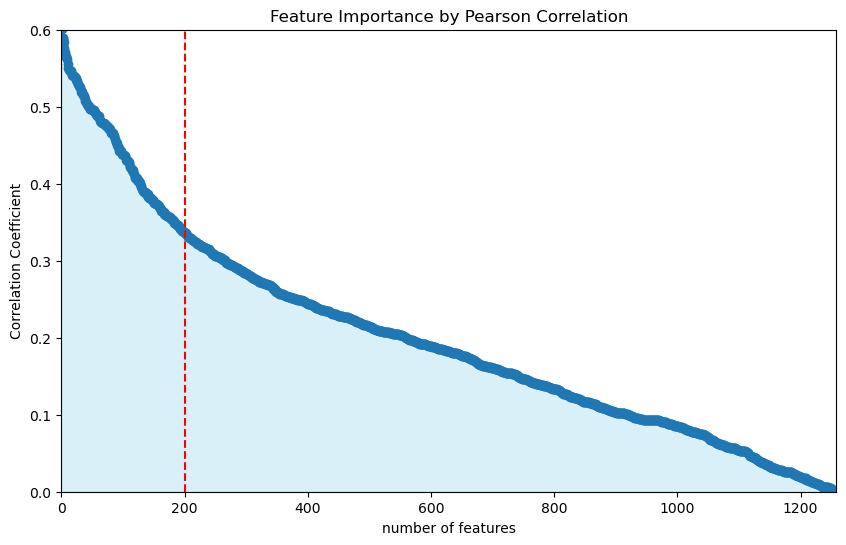

<Figure size 640x480 with 0 Axes>

In [6]:
# 特征选择
# Pearson相关系数筛选特征，并显示相关系数排列；
# 线性特征筛选
data_variance['y_true'] = y_true

Importance_corr = data_variance.corr()['y_true'].abs().sort_values(ascending=False)
# 计算data_variance中所有特征与y_true的相关系数，并按绝对值排序
# y_true是标签，与y_true相关系数最高的特征是y_true本身，所以需要去掉
Importance_corr = Importance_corr[1:]
# 绘制相关系数分布图，横坐标为特征数，纵坐标为相关系数
plt.figure(figsize=(10, 6))
plt.plot(range(len(Importance_corr)), Importance_corr, marker='o')
plt.title('Feature Importance by Pearson Correlation')
plt.xlabel('number of features')
plt.xlim(0, len(Importance_corr))
plt.ylabel('Correlation Coefficient') 
plt.ylim(0, 0.6)
# 曲线下填充颜色，坐标起点设为(0,0)，颜色设为skyblue，透明度设为0.3
plt.fill_between(range(len(Importance_corr)), Importance_corr, color='skyblue', alpha=0.3)
# 在y=200除绘制一条垂直线
plt.axvline(x=200, color='r', linestyle='--')
plt.show()
plt.savefig('feature_importance.png')



In [7]:
# 根据相关系数，保留前200个特征
# 创建空的framework
name_column = []
for i in range(200):    
    column_name = Importance_corr.index[i]
    name_column.append(column_name)

data_cor1 = data_variance.loc[:,name_column] # 重新转化为dataframe
data_cor1.to_excel('data_cor1_head200.xlsx')
data_cor1.shape

(105, 200)

In [ ]:
# 去除相关性高的两个特征中后面的那个
X_corr2 = round(data_cor1.corr().abs(),2)
correlated_features = set()  #满足某一相关性的高相关性特征集

for i in range(len(X_corr2.columns)):
    for j in range(i):
        if abs(X_corr2.iloc[i,j])>0.8:
            colname=X_corr2.columns[i]
            correlated_features.add(colname)

data_cor1.drop(labels=correlated_features,axis=1,inplace=True)  #剔除掉这些高相关性特征，剩余41个特征
data_cor1.to_excel('data_head200_rank41.xlsx')
data_cor1

,Mor13p,MATS3v,Mor25m,AETA_eta_L,Mor31v,Mor15p,AETA_beta_ns_d,AATSC3d,SlogP_VSA10,JGT10,...,AATSC1d,GATS3c,JGI3,nBase,PPSA3,Mor30se,C1SP3,Mor05m,WPSA3,C1SP2
0,0.265689,-0.131464,-0.161989,0.438744,0.356071,0.020424,0.000000,-0.009017,0.000000,0.404815,...,0.031716,0.788742,0.050000,1.0,26.401690,-0.013049,2.0,-0.955464,9.012666,0.0
1,-0.098856,0.028056,-0.363159,0.492814,0.076290,0.175717,0.000000,0.004613,0.000000,0.192392,...,0.052735,0.661848,0.025000,2.0,55.151483,-0.405377,4.0,0.539479,19.231616,0.0
2,-0.316358,0.109053,0.128117,0.256425,0.052282,0.404575,0.050000,-0.058957,0.000000,0.399505,...,0.167800,0.588319,0.045455,1.0,28.812028,-0.291525,1.0,-1.883169,9.624890,0.0
3,-0.176709,0.091394,0.242301,0.239377,0.057152,0.157751,0.050000,-0.058957,0.000000,0.399505,...,0.167800,0.587496,0.045455,1.0,29.257944,-0.296406,1.0,-1.922249,9.627758,0.0
4,0.037186,0.006599,-0.016881,0.331435,0.066651,0.208043,0.000000,-0.009070,0.000000,0.213472,...,0.042404,0.641843,0.031250,2.0,58.767485,-0.431251,4.0,-0.871394,18.062810,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
100,-0.303579,-0.397222,0.221796,0.185033,-0.000629,0.377629,0.111111,-0.174242,10.077801,0.548472,...,0.222222,0.823469,0.056250,1.0,30.532932,-0.125548,1.0,-1.794004,9.091218,0.0
101,-0.358477,-0.352662,0.585693,0.190668,-0.026708,0.392652,0.045455,-0.151796,18.858631,0.673759,...,0.040123,0.699929,0.057692,1.0,28.534831,0.097991,1.0,-1.587447,9.043624,0.0
102,-0.448172,-0.444175,0.710001,0.201555,-0.022666,0.436599,0.033333,0.015699,32.029877,0.759409,...,-0.081633,0.672125,0.068452,1.0,26.459762,0.189628,2.0,-1.949988,9.843088,0.0
103,-0.267610,-0.023120,0.278870,0.181611,-0.021700,0.476477,0.111111,-0.152778,10.077801,0.432621,...,0.194444,0.740563,0.050000,1.0,24.434346,-0.108662,0.0,-1.538127,7.209381,0.0


In [9]:
from sklearn.feature_selection import RFECV
from sklearn.svm import LinearSVC

# 对这38个特征进行RFEcv，用logistic回归模型
estimator = LogisticRegression(max_iter=1000)
# 不归一化
data_rfe = data_cor1
rfecv = RFECV(estimator=estimator, scoring='accuracy',cv=5,step=1)
rfecv.fit(data_rfe, y_true)
print('---原始数据---')
print("RFEC挑选了几个特征 : %d" % rfecv.n_features_)
print("重要性排名：",rfecv.ranking_)
print("最优特征变量:",rfecv.support_)  # 打印选择的最优特征变量

# 最大最小归一化
data_rfe_minmax = MinMaxScaler().fit_transform(data_cor1)
refcv_minmax = RFECV(estimator=estimator, scoring='accuracy',cv=5,step=1)
refcv_minmax.fit(data_rfe_minmax, y_true)
print('---最大最小归一化---')
print("RFEC挑选了几个特征 : %d" % refcv_minmax.n_features_)
print("重要性排名：",refcv_minmax.ranking_)
print("最优特征变量:",refcv_minmax.support_)  # 打印选择的最优特征变量

# 标准化
data_rfe_std = StandardScaler().fit_transform(data_cor1)
rfecv_std = RFECV(estimator=estimator, scoring='accuracy',cv=5,step=1)
rfecv_std.fit(data_rfe_std, y_true)
print('---标准化---')
print("RFEC挑选了几个特征 : %d" % rfecv_std.n_features_)
print("重要性排名：",rfecv_std.ranking_)
print("最优特征变量:",rfecv_std.support_)  # 打印选择的最优特征变量

---原始数据---
RFEC挑选了几个特征 : 35
重要性排名： [1 1 1 1 1 1 1 1 1 3 1 1 1 1 1 7 1 1 1 1 2 1 1 4 1 1 1 1 1 1 1 1 1 6 1 1 1
 5 1 1 1]
最优特征变量: [ True  True  True  True  True  True  True  True  True False  True  True
  True  True  True False  True  True  True  True False  True  True False
  True  True  True  True  True  True  True  True  True False  True  True
  True False  True  True  True]
---最大最小归一化---
RFEC挑选了几个特征 : 37
重要性排名： [1 1 1 1 1 1 3 1 1 1 1 1 1 1 1 5 1 1 1 1 1 1 1 1 2 1 1 1 1 1 1 1 1 1 1 1 1
 1 4 1 1]
最优特征变量: [ True  True  True  True  True  True False  True  True  True  True  True
  True  True  True False  True  True  True  True  True  True  True  True
 False  True  True  True  True  True  True  True  True  True  True  True
  True  True False  True  True]
---标准化---
RFEC挑选了几个特征 : 11
重要性排名： [ 1 17 31 30 12 18  4  3  7 14  1 21 26  1 11 29  1 28  8 16 15  9  1 20
  1  1 24  1  5  1  2  1 10 25 13 23  1 22 19  6 27]
最优特征变量: [ True False False False False False False False False False  True Fals

In [10]:
# 保留最优特征变量, 根据标准化的结果，保留这11个特征
data_rfe_std_11 = data_cor1.iloc[:,rfecv_std.support_]
data_rfe_std_11.to_excel('data_rfecv_std_rank11.xlsx')
# 
data_rfe_minmax_37 = data_cor1.iloc[:,refcv_minmax.support_]
data_rfe_minmax_37.to_excel('data_rfecv_minmax_rank37.xlsx')

data_rfe_non_35 = data_cor1.iloc[:,rfecv.support_]
data_rfe_non_35.to_excel('data_rfecv_non_rank35.xlsx')


In [11]:
data_rfe_std_11

,Mor13p,RotRatio,Mor27v,AATSC2d,MATS3Z,MATS1dv,BCUTs-1l,SsNH3,Mor23m,AATSC1d,Mor30se
0,0.265689,0.571429,0.162061,-0.065335,-0.152152,0.157293,1.251350,3.910269,-0.033603,0.031716,-0.013049
1,-0.098856,0.714286,0.015869,-0.021314,-0.060768,-0.104010,0.537841,7.467058,0.152152,0.052735,-0.405377
2,-0.316358,0.200000,-0.121168,-0.004724,0.041068,0.340193,1.043339,3.801241,-0.308611,0.167800,-0.291525
3,-0.176709,0.200000,-0.094168,-0.004724,0.096249,0.361119,1.297959,3.763433,-0.074306,0.167800,-0.296406
4,0.037186,0.666667,0.086501,-0.029540,0.013462,0.200683,1.385557,7.224167,0.051547,0.042404,-0.431251
...,...,...,...,...,...,...,...,...,...,...,...
100,-0.303579,0.000000,-0.182299,-0.116667,-0.252969,0.381579,1.450322,3.582500,-0.221826,0.222222,-0.125548
101,-0.358477,0.000000,-0.179989,-0.111728,-0.060176,0.257282,1.219038,3.476378,-0.462246,0.040123,0.097991
102,-0.448172,0.000000,-0.236199,-0.049320,-0.068889,0.254144,1.217587,3.068889,-0.710908,-0.081633,0.189628
103,-0.267610,0.111111,-0.151085,-0.033333,0.115143,0.324074,1.400868,0.000000,-0.192776,0.194444,-0.108662


### 解释以上11个描述符的含义
##### 都可以在https://mordred-descriptor.github.io/documentation/master/descriptors.html 上查找定义
#### MoRSE描述符——4个
<p>Mor13p:3D-MoRSE weighted by polarizability (distance = 13)
<p>Mor27v: 3D-MoRSE weighted by vdw volume (distance = 27)
<p>Mor23m: 3D-MoRSE weighted by mass (distance = 23)
<p>Mor30se: 3D-MoRSE weighted by sanderson EN (distance = 30)
<p>参考文献：3D-MoRSE descriptors explained, 3D-MoRSE 表示基于电子衍射描述符的结构的 3D 分子表示;3D-MoRSE 描述符取决于原子间距离（散射参数等于零的情况除外）

#### ATS描述符——2个
<p> AATSC2d: averaged and centered moreau-broto autocorrelation of lag 2 weighted by sigma electrons
<p> AATSC1d: averaged and centered moreau-broto autocorrelation of lag 1 weighted by sigma electrons
<p>averaged and centered moreau-broto autocorrelation of lag 2 weighted by sigma electrons
<p>Moreau Broto Autocorrelation is also known as Autocorrelation of a Topological Structure (ATS). The ATS descriptor describes how a property is distributed along the topological structure. 拓扑结构自相关；描述了属性如何沿拓扑结构分布。(http://www.rguha.net/writing/notes/desc/node2.html)


#### 莫兰系数——2个
<p> MATS3Z: moran coefficient of lag 3 weighted by atomic number
<p> MATS1dv: moran coefficient of lag 1 weighted by valence electrons
<p>空间相关性指数 (http://www.rguha.net/writing/notes/desc/node2.html#SECTION00022000000000000000)



#### RotRatio
<p>rotatable bonds ratio

#### BCUTs-1l
<p>first lowest eigenvalue of Burden matrix weighted by intrinsic state
<p>BCUT – Eigenvalue Based Descriptor;
<p>Eigenvalue based descriptor noted for its utility in chemical diversity. Described by Pearlman et al. The descriptor is based on a weighted version of the Burden matrix which takes into account both the connectivity as well as atomic properties of a molecule. The weights are a variety of atom properties placed along the diagonal of the Burden matrix.参考：https://nanx.me/Rcpi/reference/extractDrugBCUT.html
<p> Burden matrix: https://chempedia.info/info/the_burden_matrix/

#### SsNH3	
<p> sum of sNH3